In [3]:
import sys
import os
current_dir = os.getcwd()  
project_root = os.path.dirname(current_dir)  
sys.path.insert(0, project_root) 
import numpy as np
import pandas as pd
from pycaret.regression import load_model, predict_model
from src.config.config import Config
from src.data.data_loader import DataLoader
from src.features.feature_engineering import FeatureEngineering
from src.visualization.visualizer import Visualizer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def predict_test_set(test_data: pd.DataFrame, model_path: str):
    """预测测试集结果并返回评估指标

    Args:
        test_data: 测试数据集
        model_path: 模型文件路径
        test_type: 测试类型，'country' 或 'time'

    Returns:
        dict: 包含预测结果和评估指标的字典
    """
    target_column = Config.DATA_CONFIG['target_column']
    method = Config.FEATURE_CONFIG['target_transform_method']
    transformed_column = f'{target_column}_{method}'
    target_column_pred = f'{target_column}_pred'

    # 加载模型
    model = load_model(model_path)
    
    # 预测
    predictions = predict_model(model, data=test_data)

    # 处理预测结果
    test_results = test_data.copy()
    test_results[target_column_pred] = np.expm1(predictions['prediction_label'])
    test_results[target_column] = np.expm1(test_results[transformed_column])
    test_results['prediction_label'] = predictions['prediction_label']

    # 新增原始值误差指标（用于业务解释）
    raw_errors = test_results[target_column_pred] - test_results[target_column]
    test_results['Abs_Percent_Error'] = (raw_errors / test_results[target_column]).abs() * 100
    
    # 计算对数空间误差
    y_true_log = test_results[transformed_column]
    y_pred_log = predictions['prediction_label']
    
    # 计算原始空间误差
    y_true = test_results[target_column]
    y_pred = test_results[target_column_pred]

    # 计算指标
    metrics = {
        # 对数空间
        'MAE_log': mean_absolute_error(y_true_log, y_pred_log),
        'RMSE_log': np.sqrt(mean_squared_error(y_true_log, y_pred_log)),
        'R2_log': r2_score(y_true_log, y_pred_log),
        
        # 原始空间
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R2': r2_score(y_true, y_pred),
        'MAPE': np.mean(test_results['Abs_Percent_Error']),
        'Median_APE': np.median(test_results['Abs_Percent_Error'])
    }
    
    print("\n模型评估指标:")
    print("【对数空间】")
    print(f"MAE: {metrics['MAE_log']:.4f}  RMSE: {metrics['RMSE_log']:.4f}  R²: {metrics['R2_log']:.4f}")
    print("\n【原始空间】")
    print(f"MAE: {metrics['MAE']:,.2f}  RMSE: {metrics['RMSE']:,.2f}  R²: {metrics['R2']:.4f}")
    print(f"MAPE: {metrics['MAPE']:.2f}%  Median APE: {metrics['Median_APE']:.2f}%")

    return test_results

In [4]:
# 加载数据
data_loader = DataLoader(Config.DATA_CONFIG['data_path'])
feature_engineering = FeatureEngineering()

# 加载训练集和测试集
train_data = pd.read_csv(os.path.join(Config.PATH_CONFIG['data_dir'], 'train.csv'))
country_test_data = pd.read_csv(os.path.join(Config.PATH_CONFIG['data_dir'], 'test.csv'))
time_test_data = pd.read_csv(os.path.join(Config.PATH_CONFIG['data_dir'], 'time_test_data.csv'))

# 模型路径
model_path = os.path.join(Config.PATH_CONFIG['models_dir'], 'catboost_250326_004944')

# Predict country test set
print('\nCountry test set predictions:')
country_results = predict_test_set(country_test_data, model_path)

# Predict time test set
print('\nTime test set predictions:')
time_results = predict_test_set(time_test_data, model_path)

visualizer = Visualizer()


Country test set predictions:
Transformation Pipeline and Model Successfully Loaded

模型评估指标:
【对数空间】
MAE: 0.0730  RMSE: 0.0953  R²: 0.9958

【原始空间】
MAE: 8,846,704.17  RMSE: 13,388,693.01  R²: 0.9830
MAPE: 7.12%  Median APE: 5.39%

Time test set predictions:
Transformation Pipeline and Model Successfully Loaded

模型评估指标:
【对数空间】
MAE: 0.3312  RMSE: 0.4676  R²: 0.9569

【原始空间】
MAE: 85,956,069.26  RMSE: 232,023,868.86  R²: 0.9620
MAPE: 35.49%  Median APE: 21.69%


In [5]:
# Print available countries
countries = sorted(country_results['Country Name'].unique())
print('\nCountry Available countries:')
for i, country in enumerate(countries, 1):
    print(f'{i}. {country}')

# Print available countries
countries = sorted(time_results['Country Name'].unique())
print('\nTime Available countries:')
for i, country in enumerate(countries, 1):
    print(f'{i}. {country}')


Country Available countries:
1. Bosnia and Herzegovina
2. Czechia
3. Finland
4. Germany
5. Japan
6. Slovenia

Time Available countries:
1. Albania
2. Austria
3. Belgium
4. Bulgaria
5. China
6. Croatia
7. Cyprus
8. Denmark
9. Estonia
10. France
11. Greece
12. Hungary
13. Iceland
14. Ireland
15. Italy
16. Latvia
17. Lithuania
18. Luxembourg
19. Malta
20. Montenegro
21. Netherlands
22. North Macedonia
23. Norway
24. Poland
25. Portugal
26. Romania
27. Serbia
28. Slovak Republic
29. Spain
30. Sweden
31. Turkiye
32. United Kingdom
33. United States


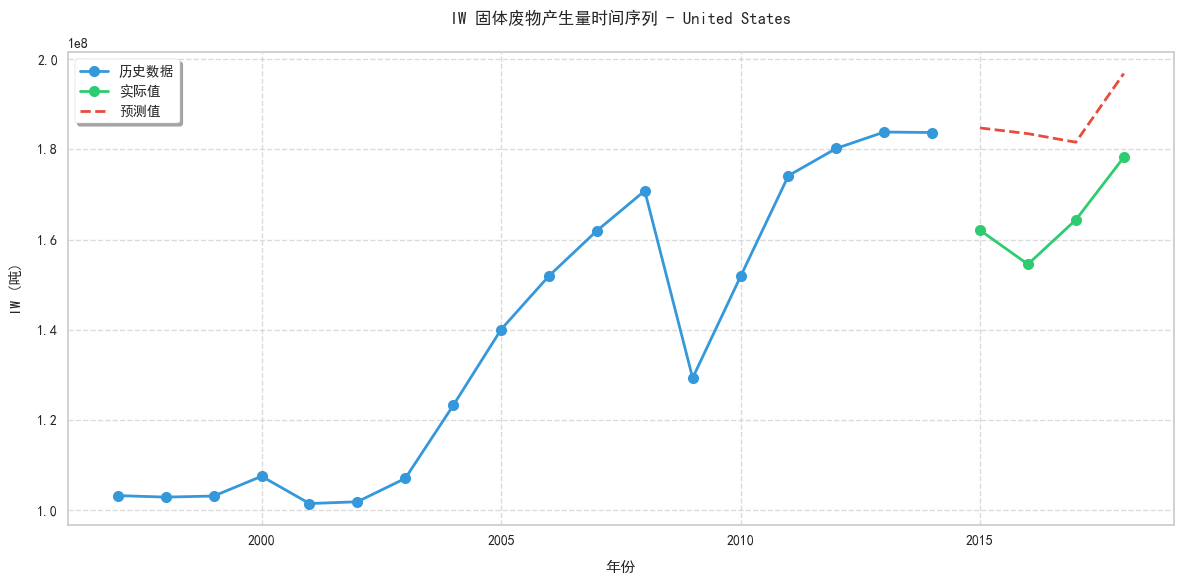

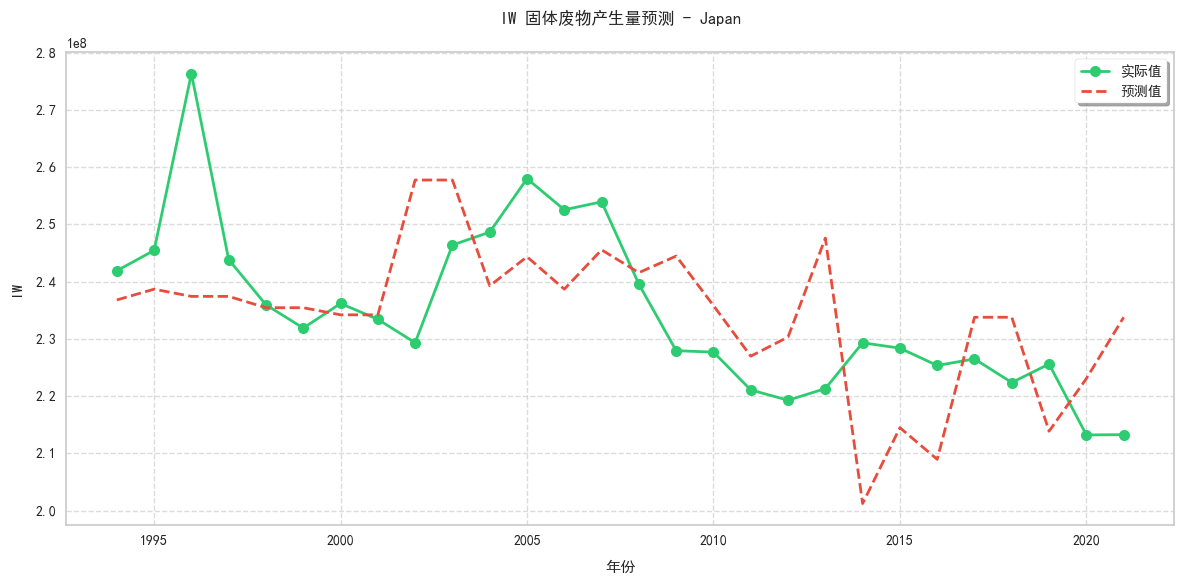

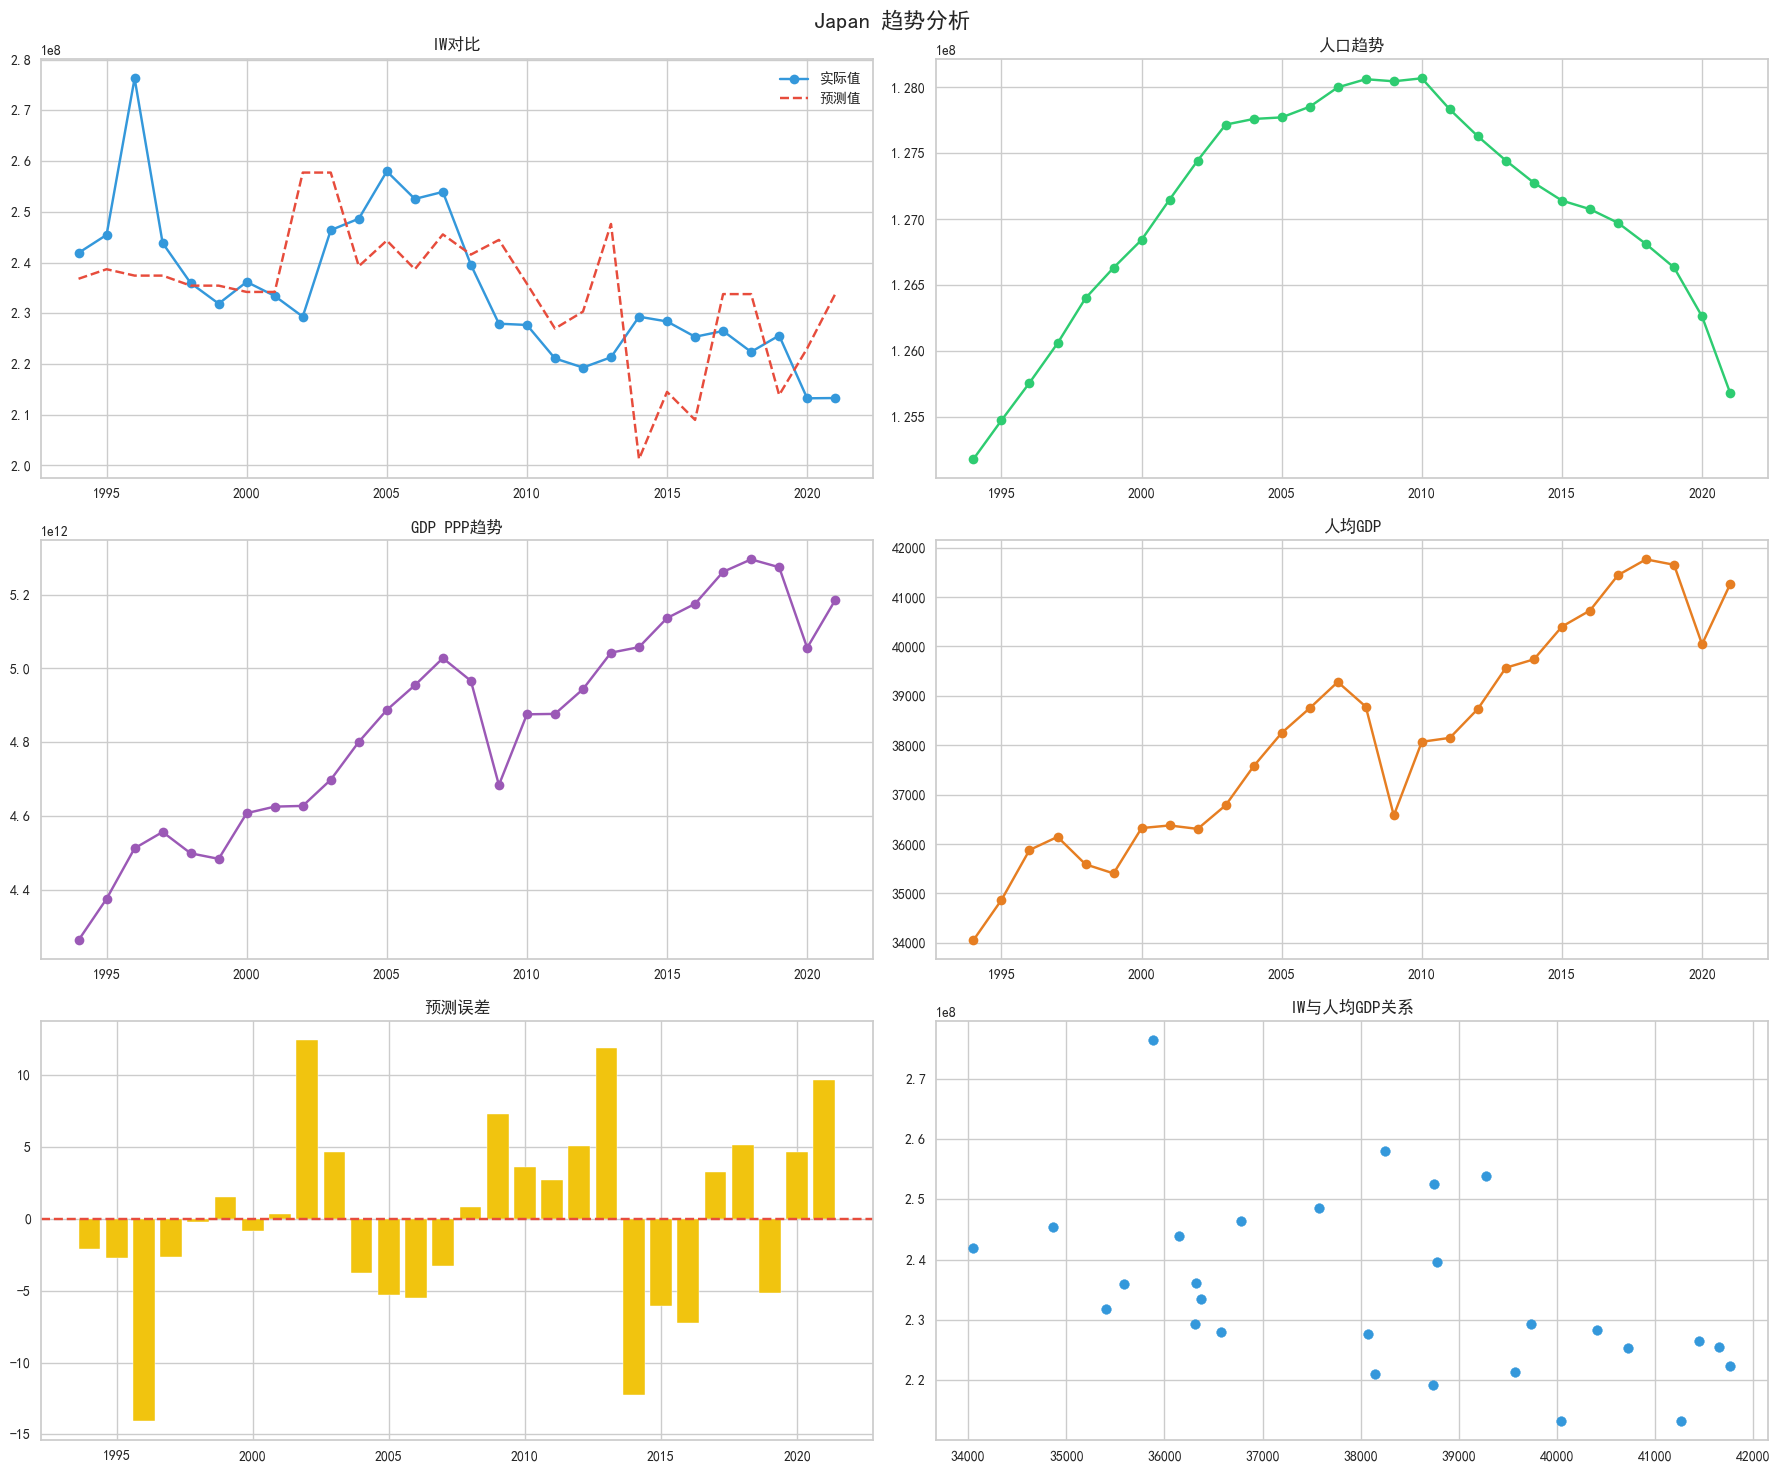

In [6]:
country = 'United States'
train = train_data[train_data['Country Name'] == country].sort_values('Year')
test = time_results[time_results['Country Name'] == country].sort_values('Year')
visualizer.plot_time_predictions(country, train, test)

country = 'Japan'
test = country_results[country_results['Country Name'] == country].sort_values('Year')
visualizer.plot_country_predictions(country,test)
visualizer.plot_country_multiple_metrics(country,test)

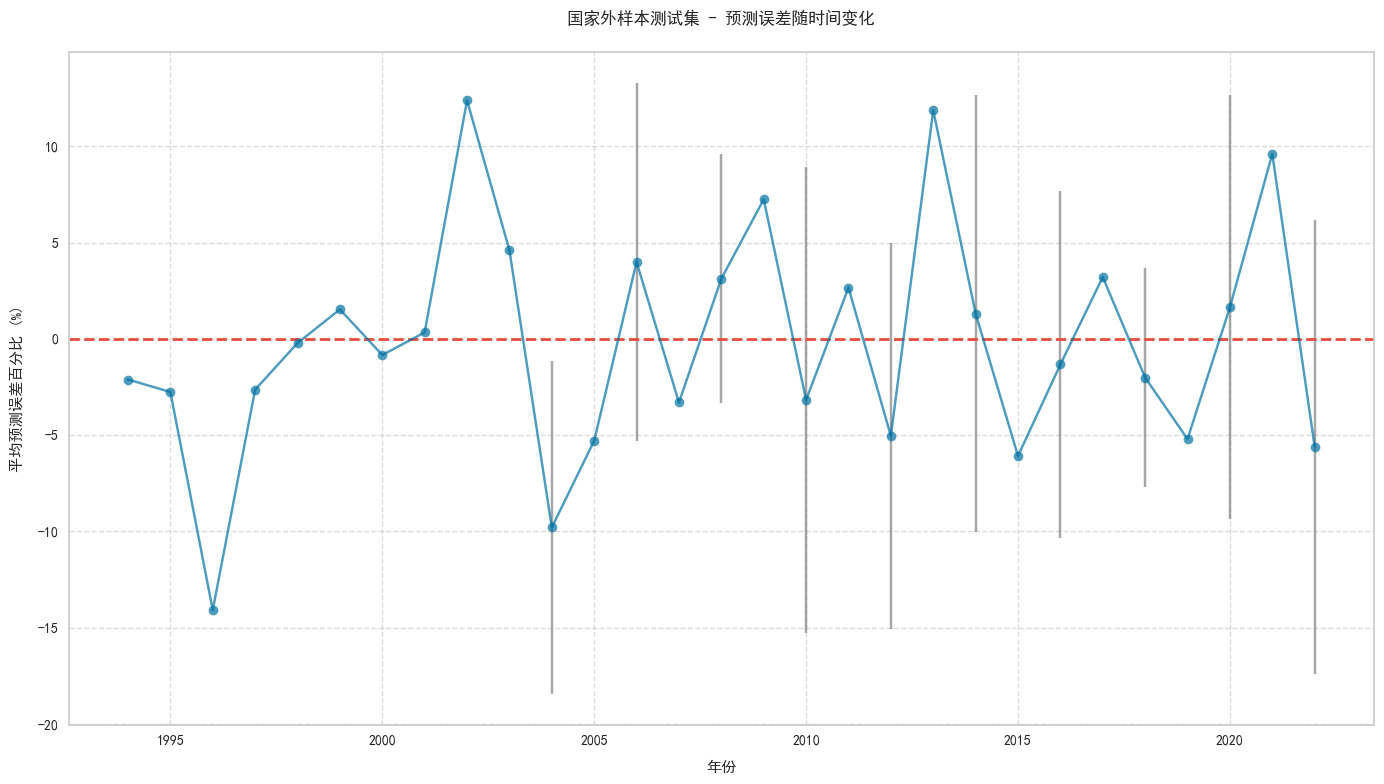

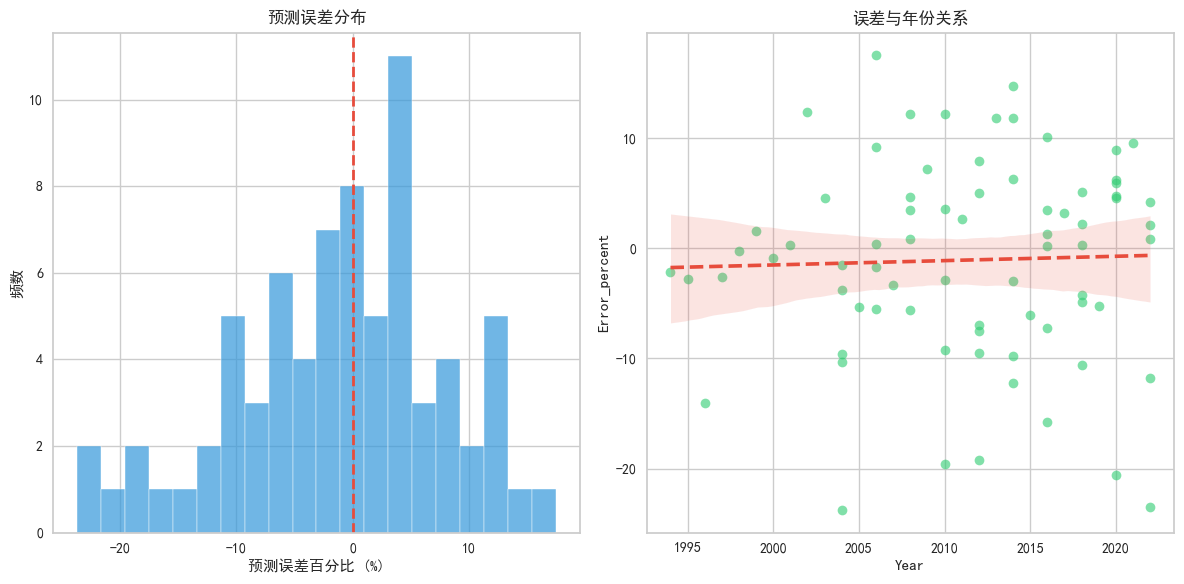

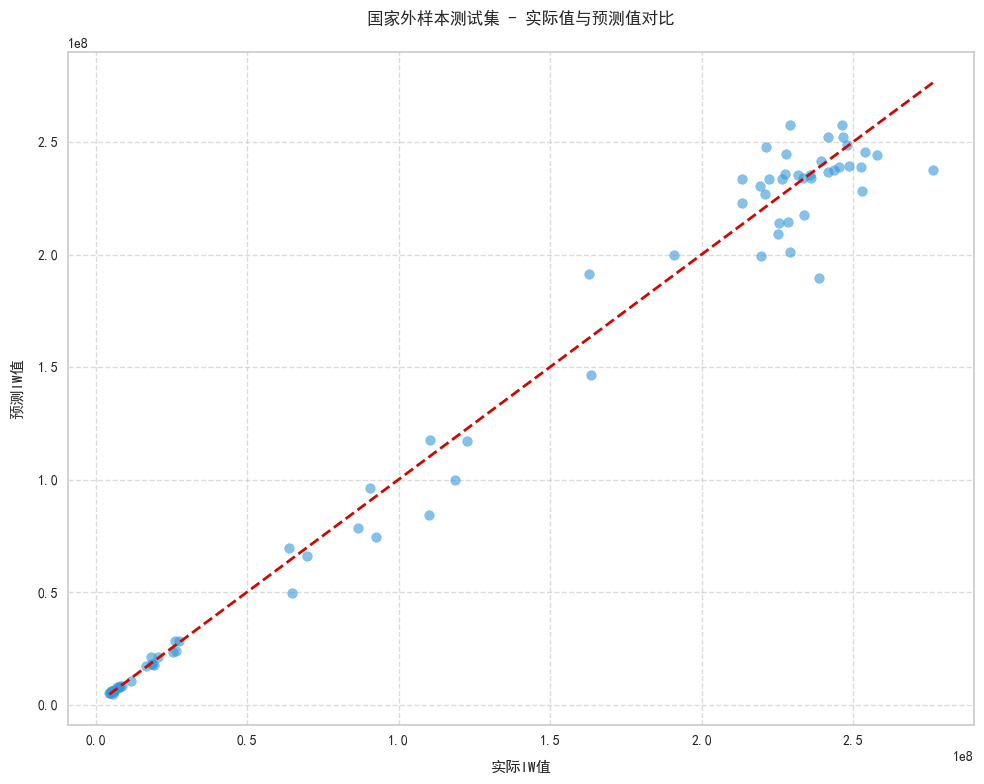

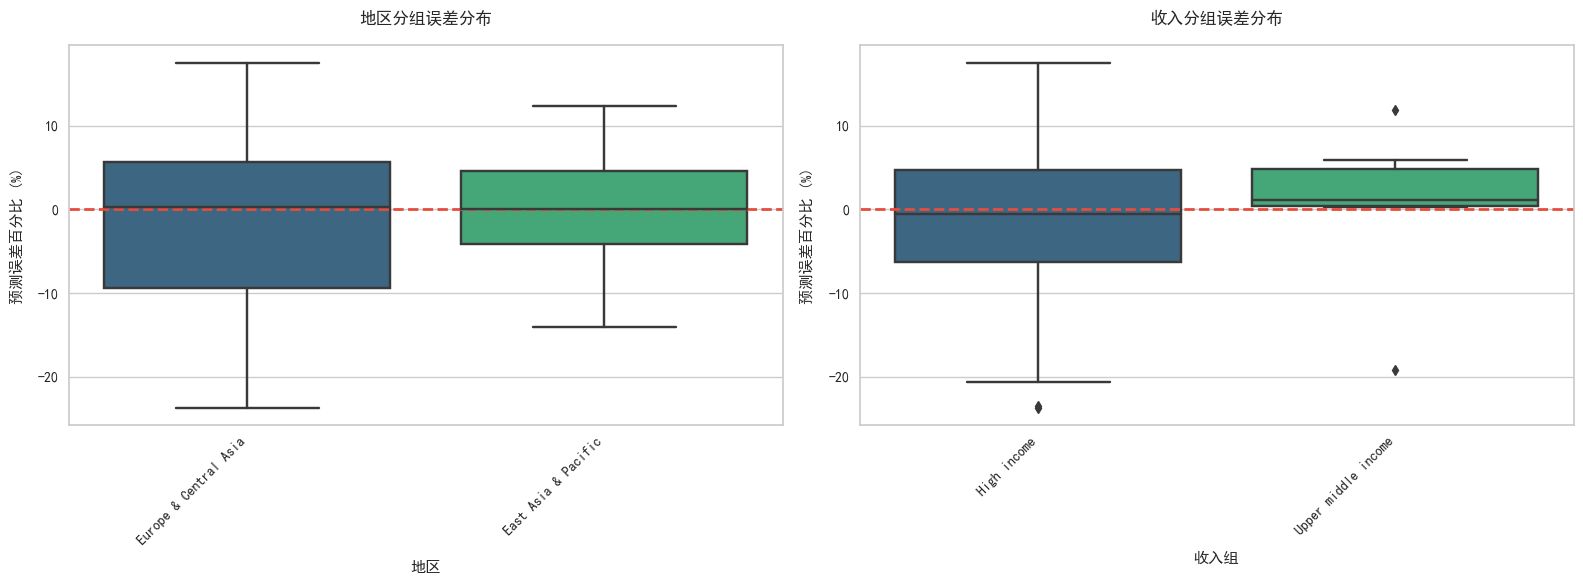

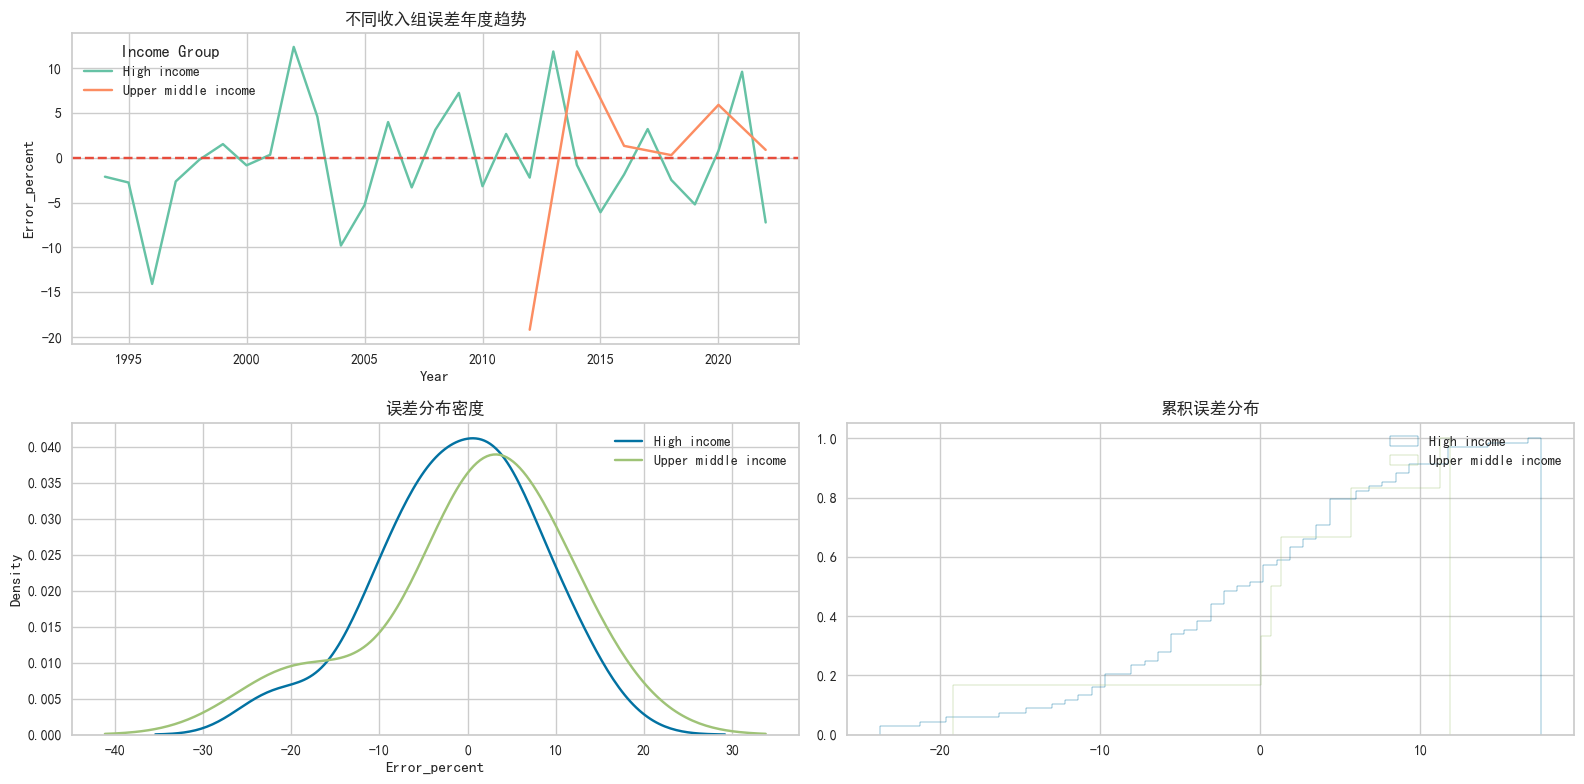

In [7]:
visualizer.plot_overall_performance(country_results)

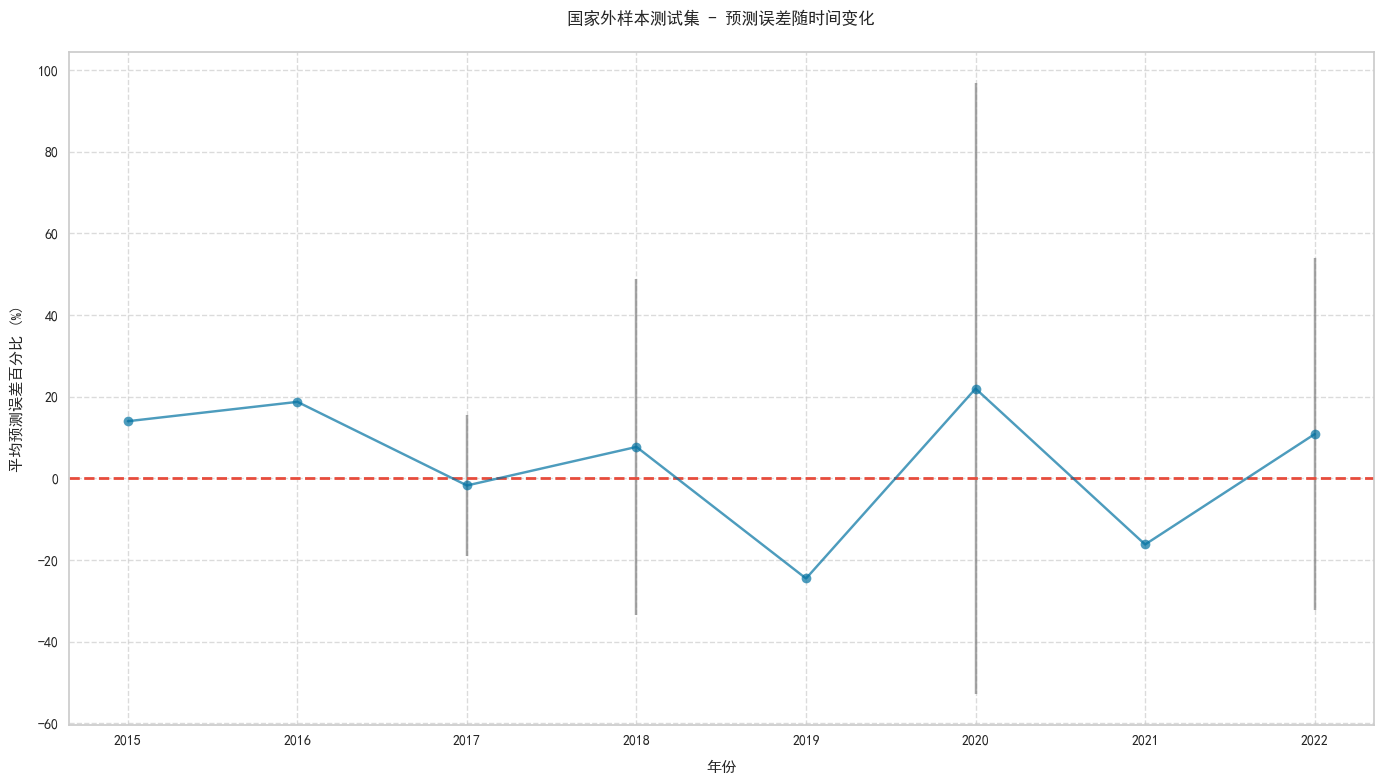

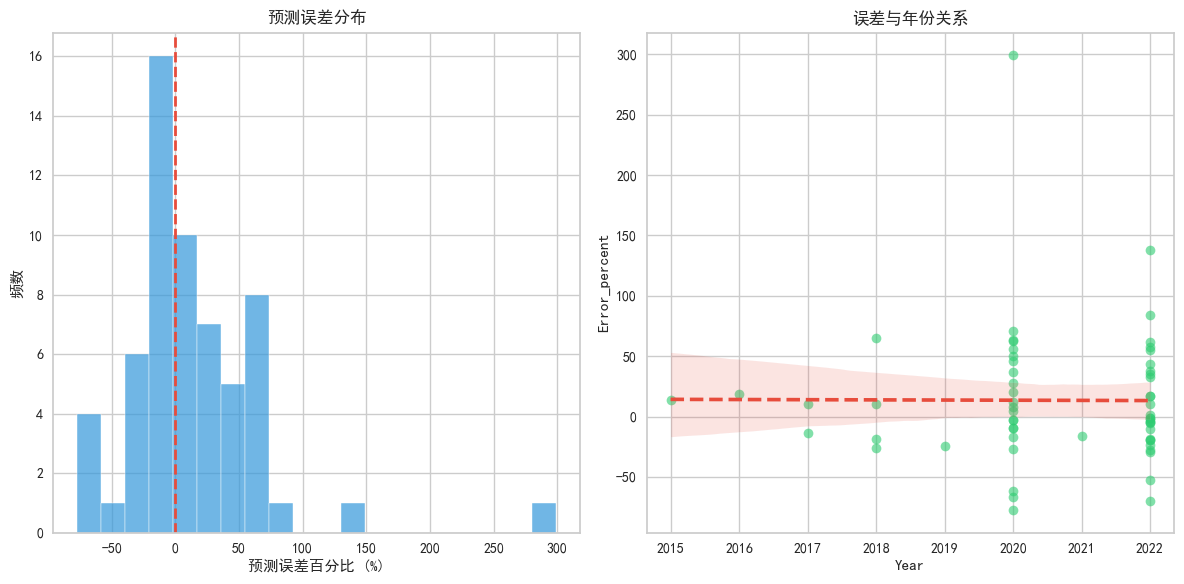

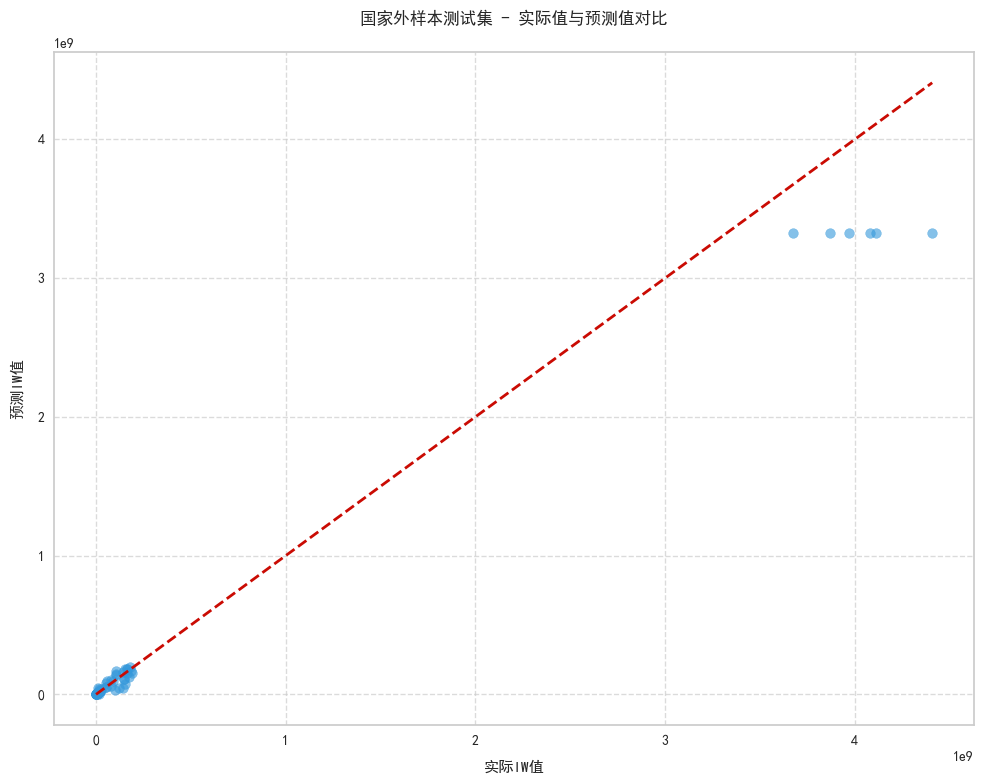

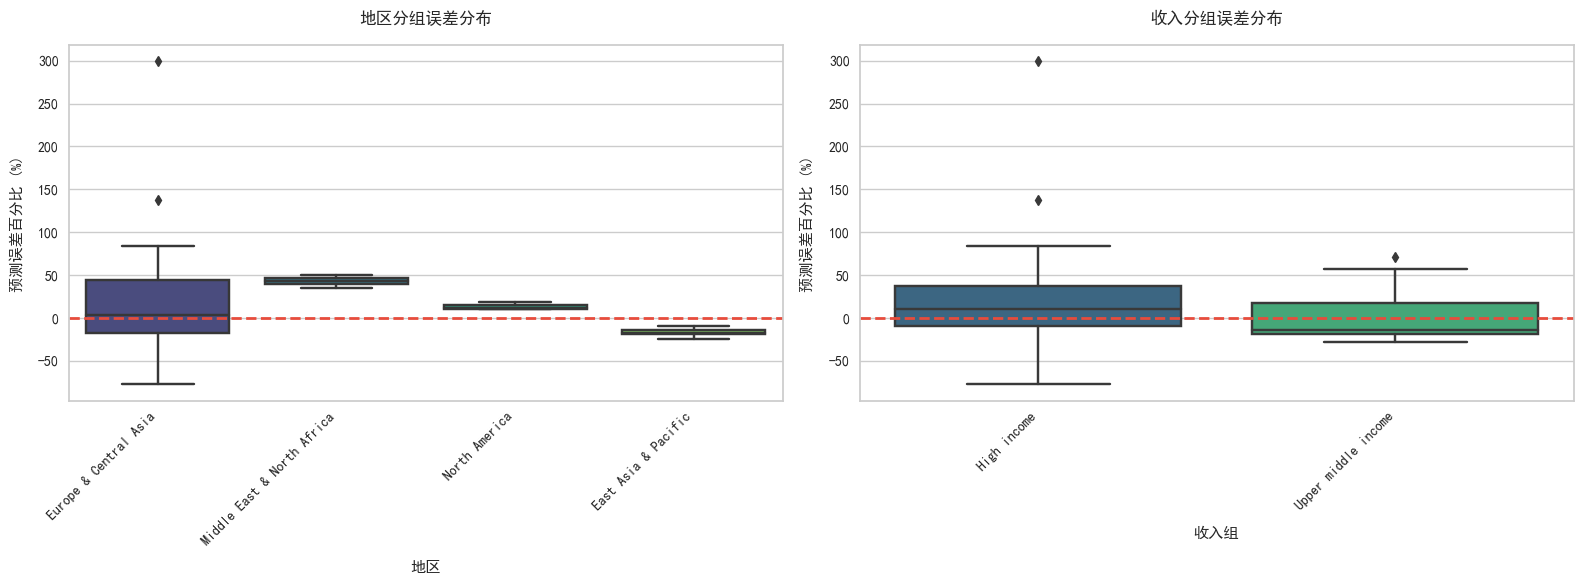

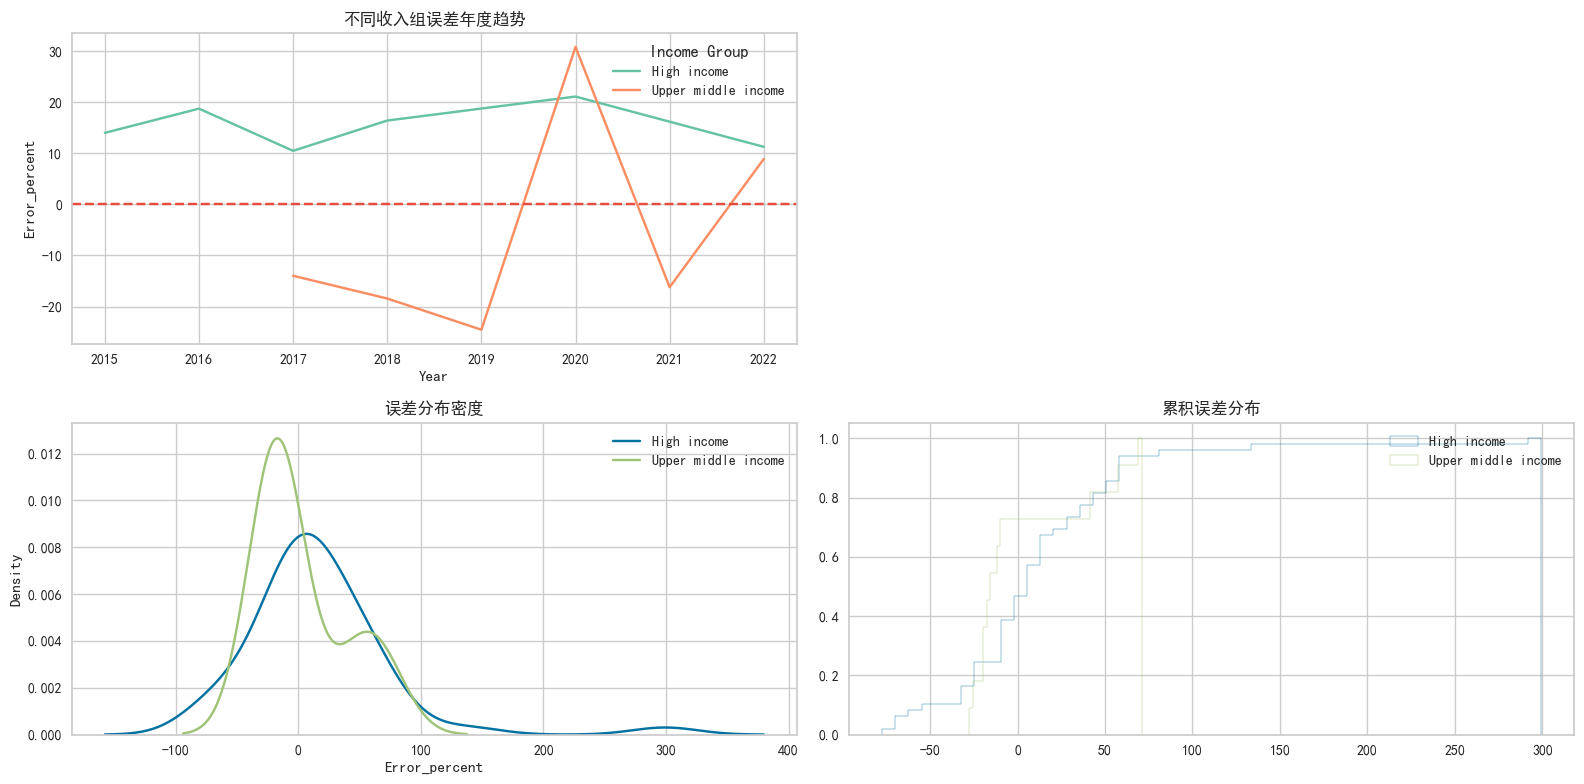

In [8]:
visualizer.plot_overall_performance(time_results)

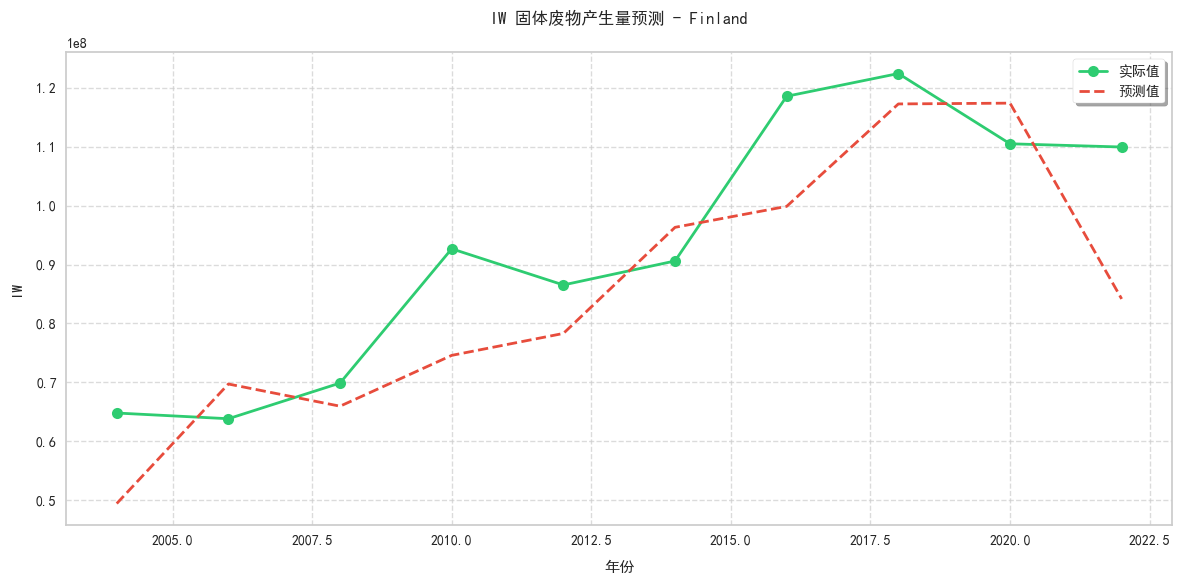

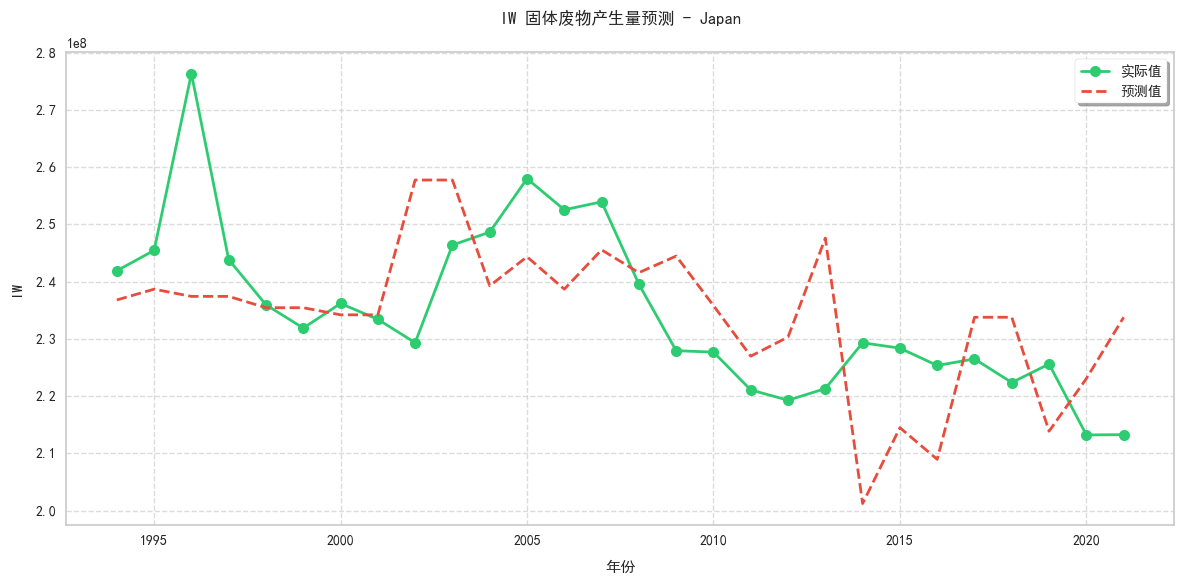

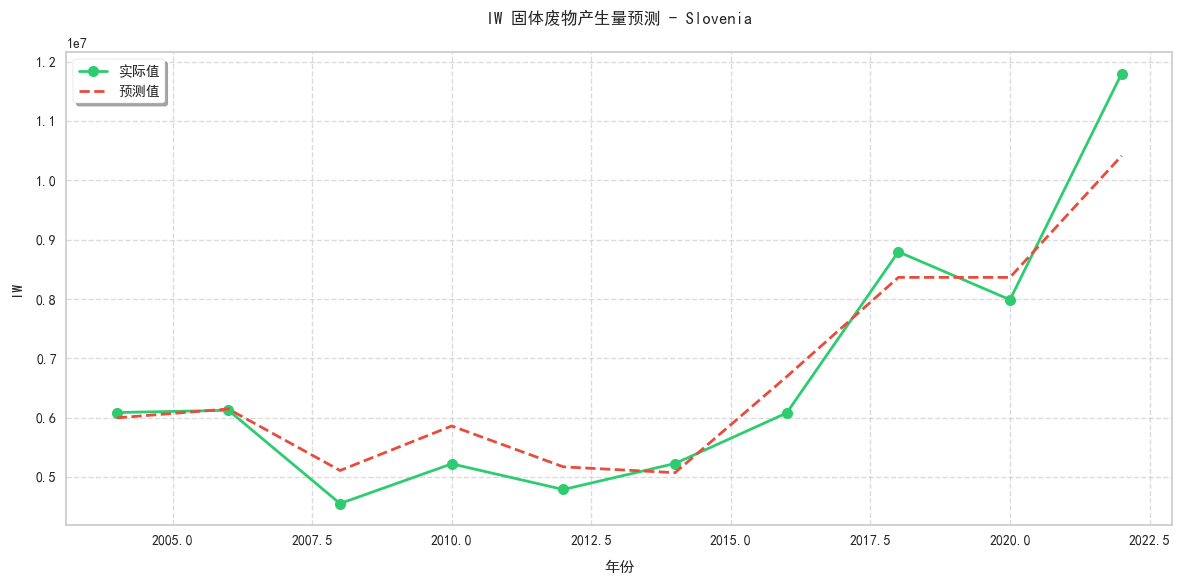

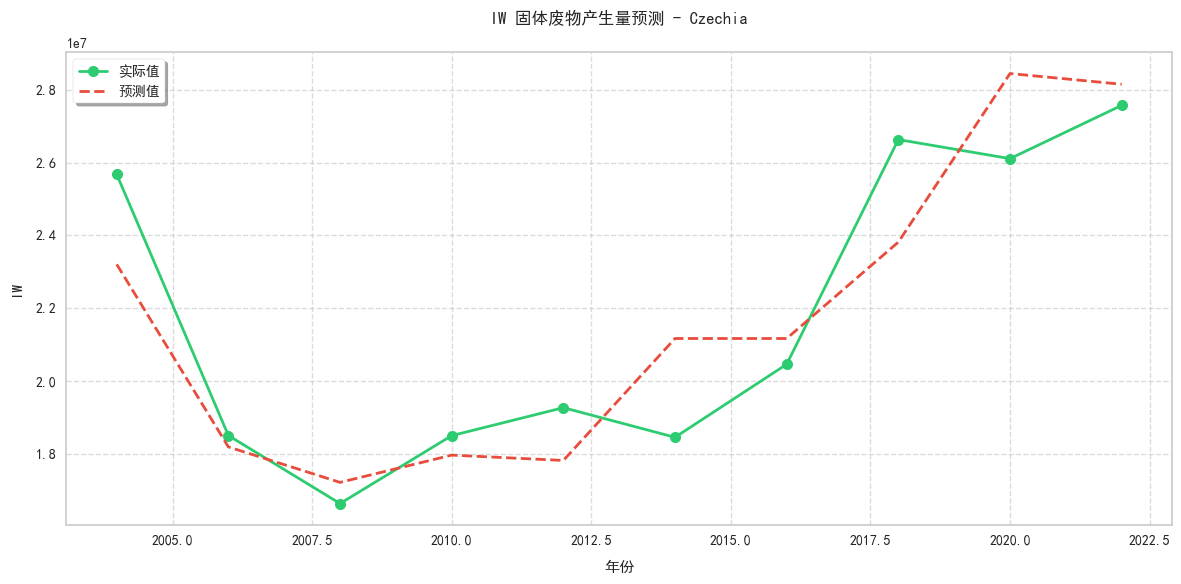

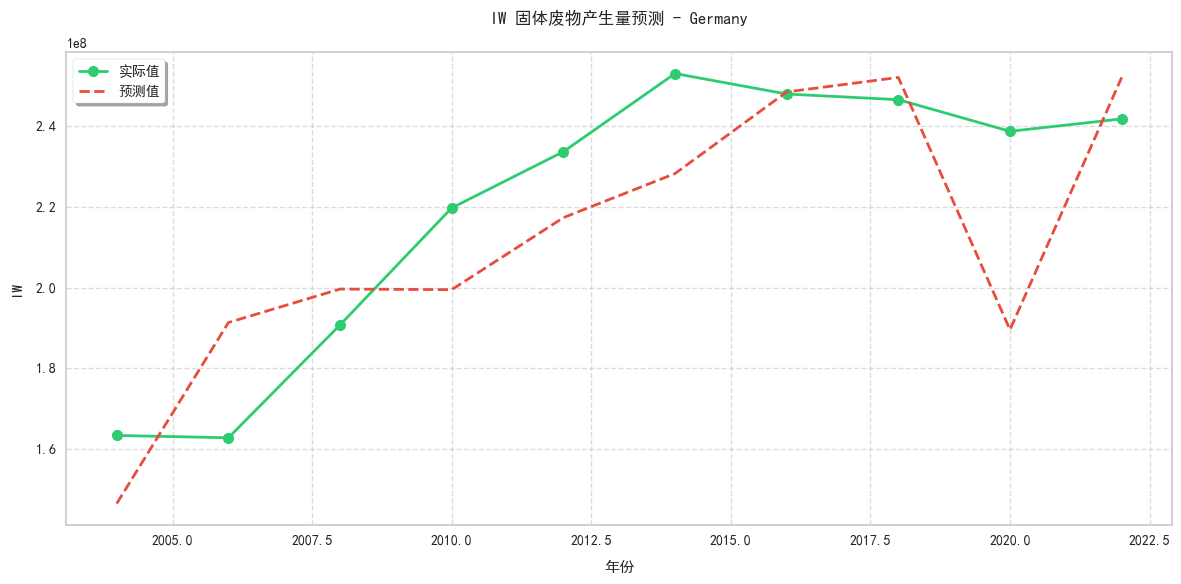

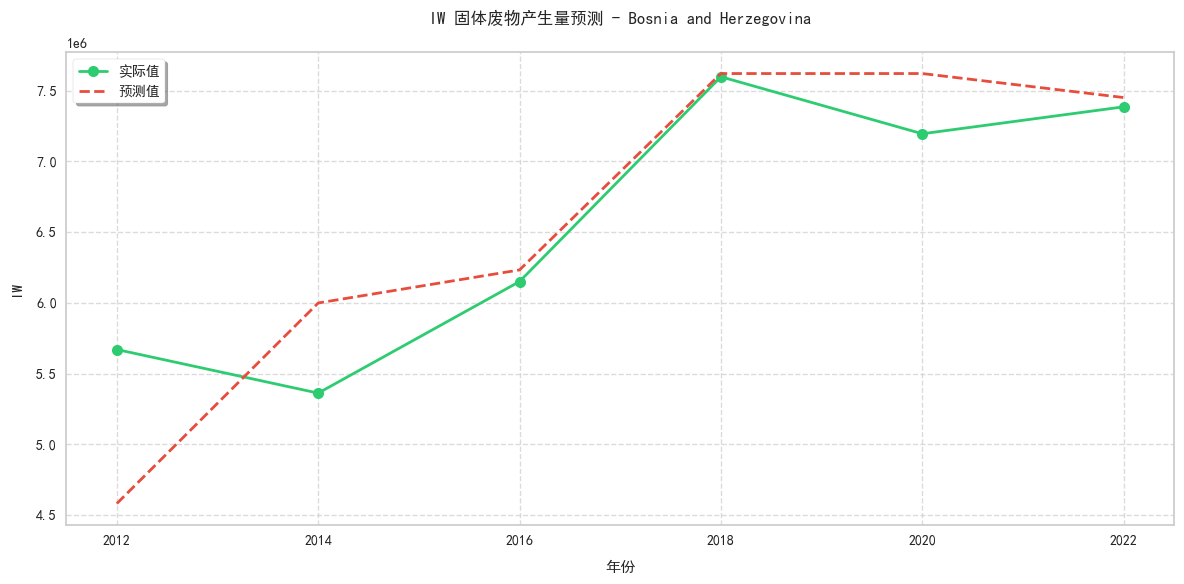

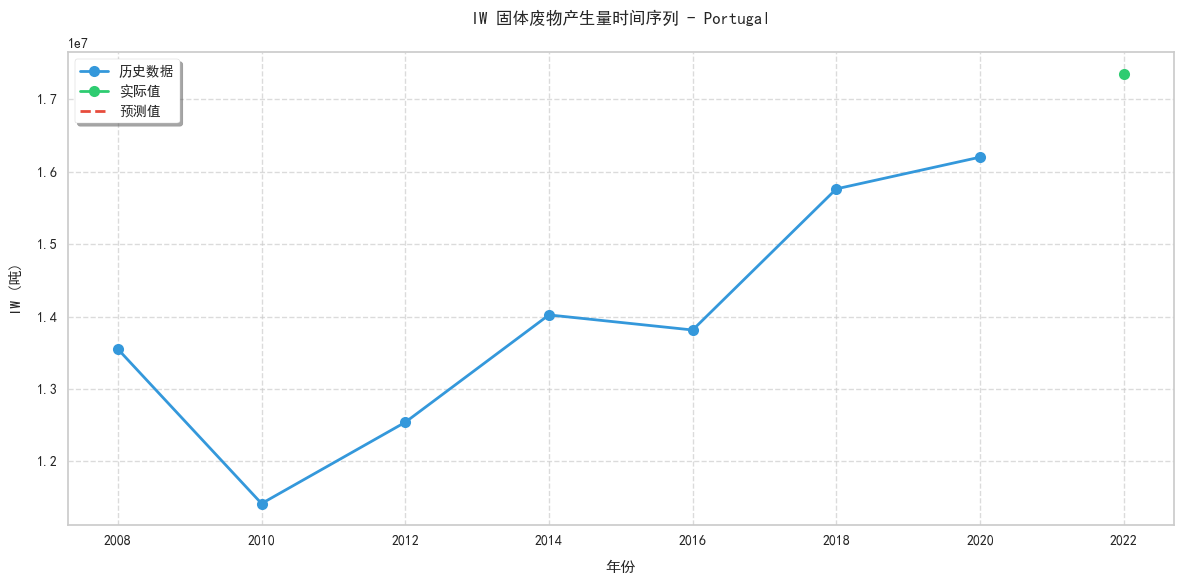

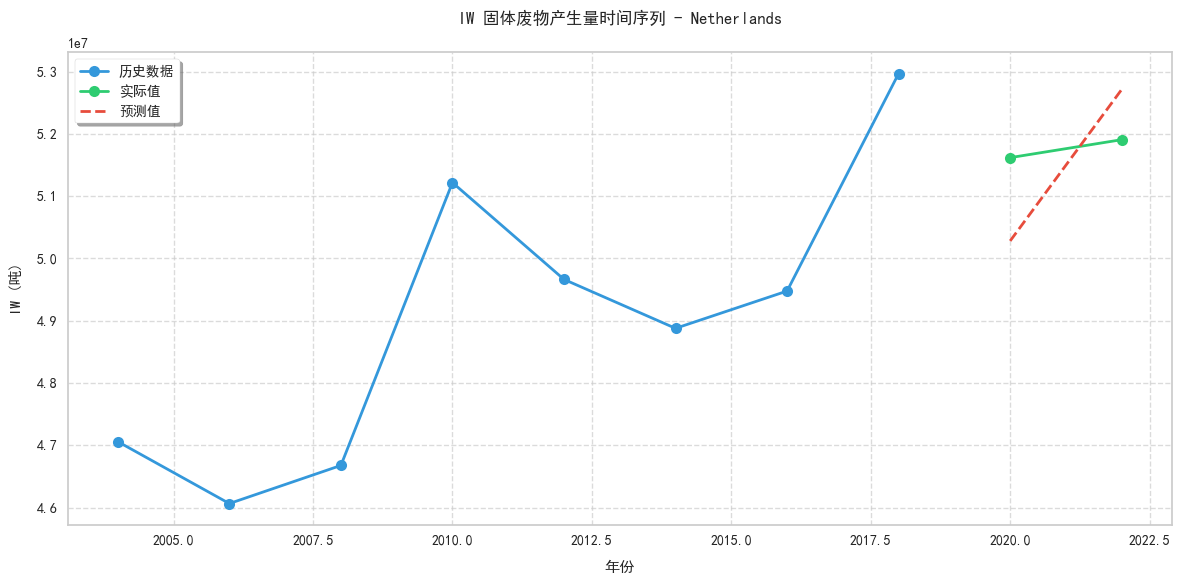

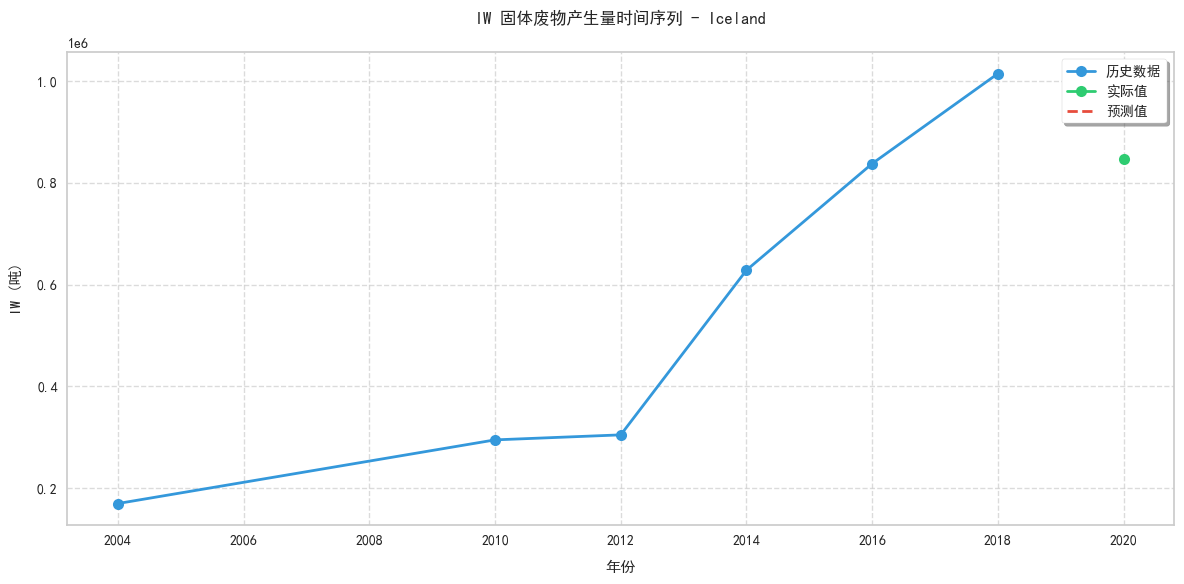

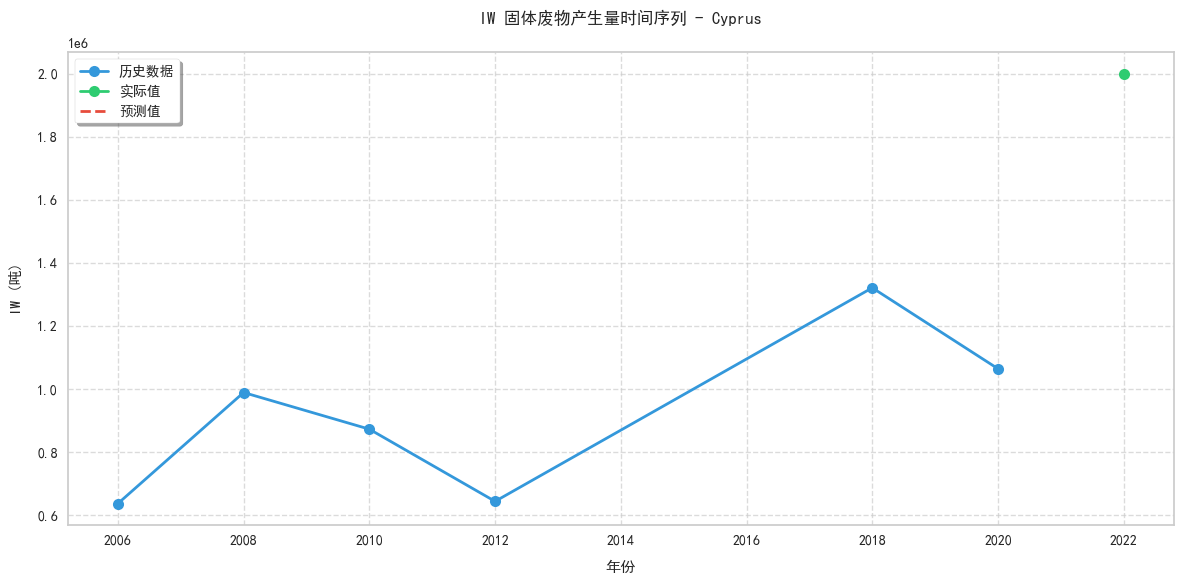

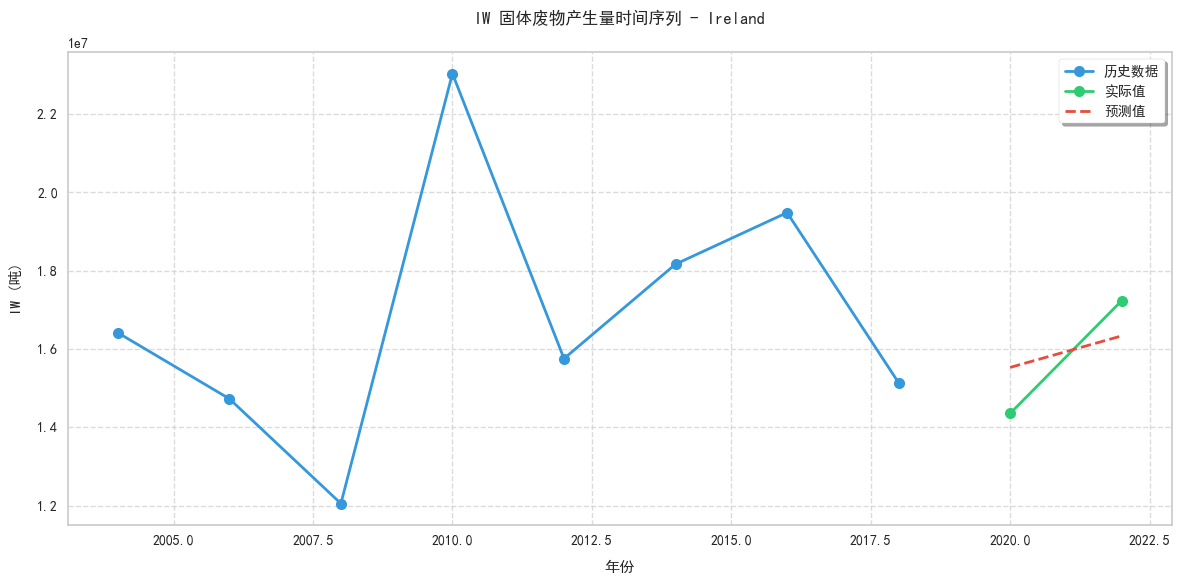

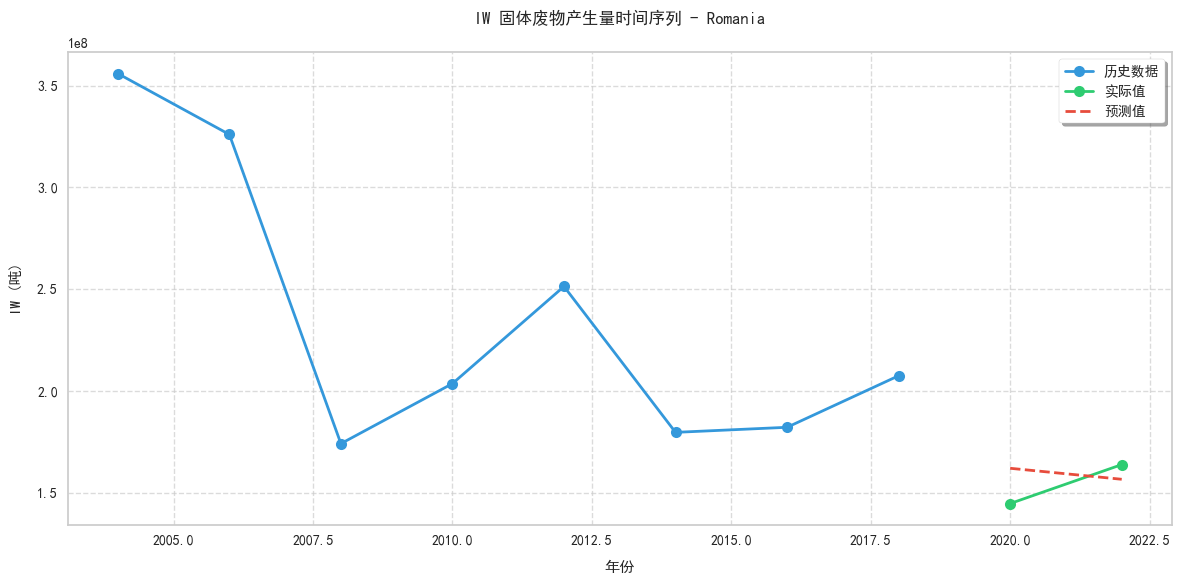

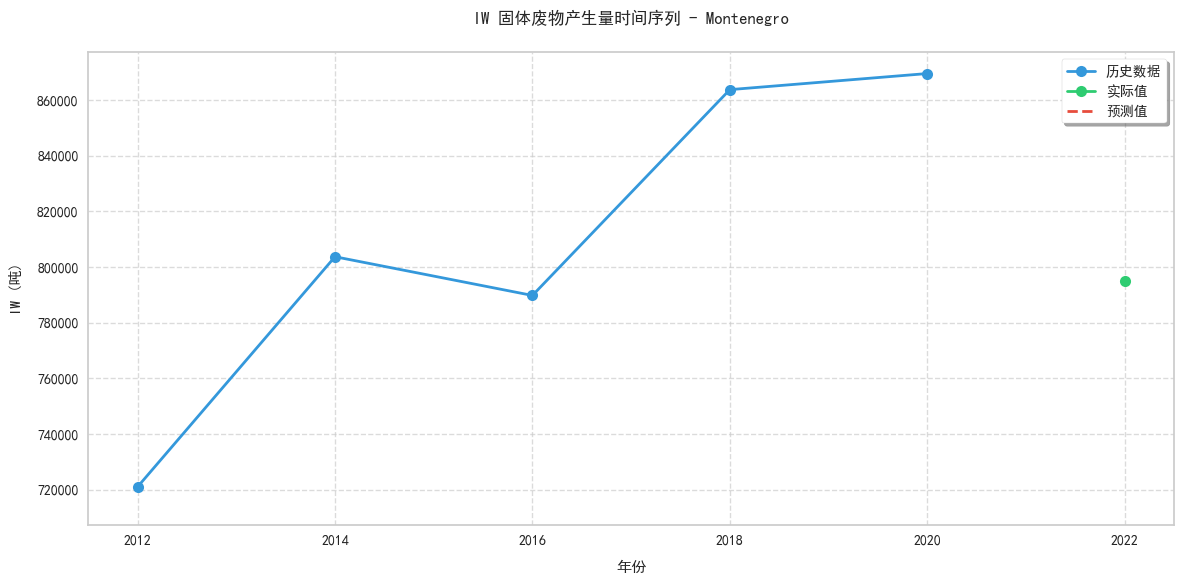

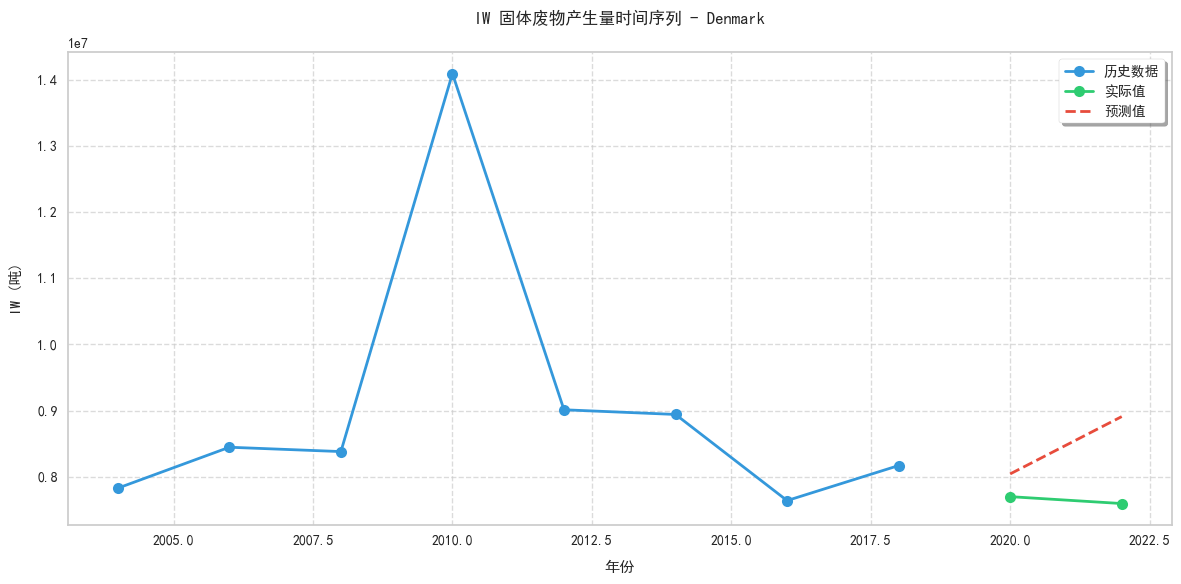

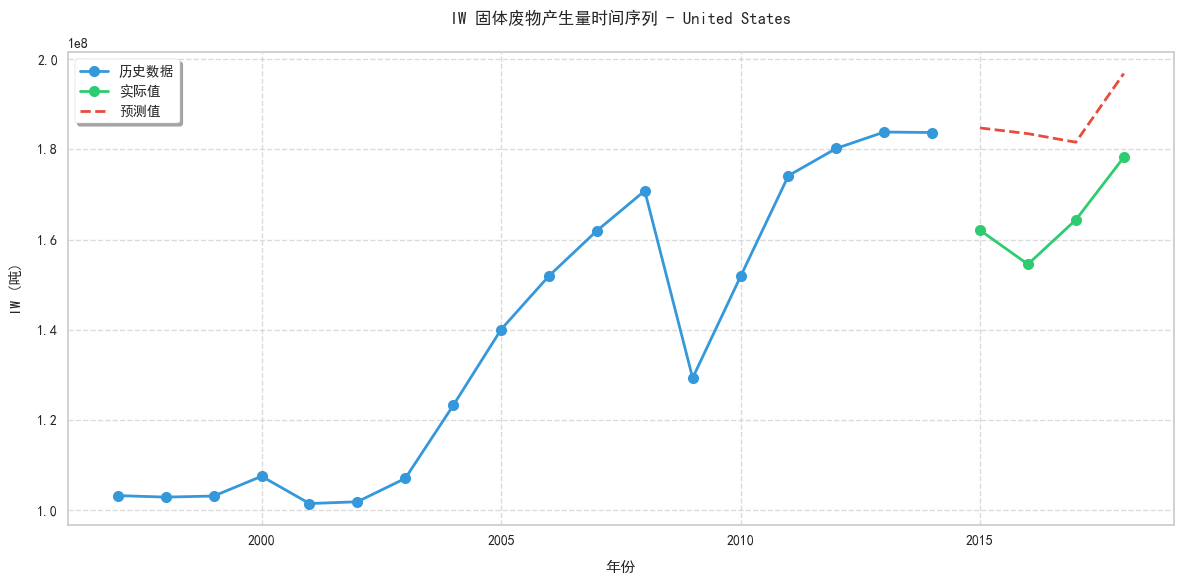

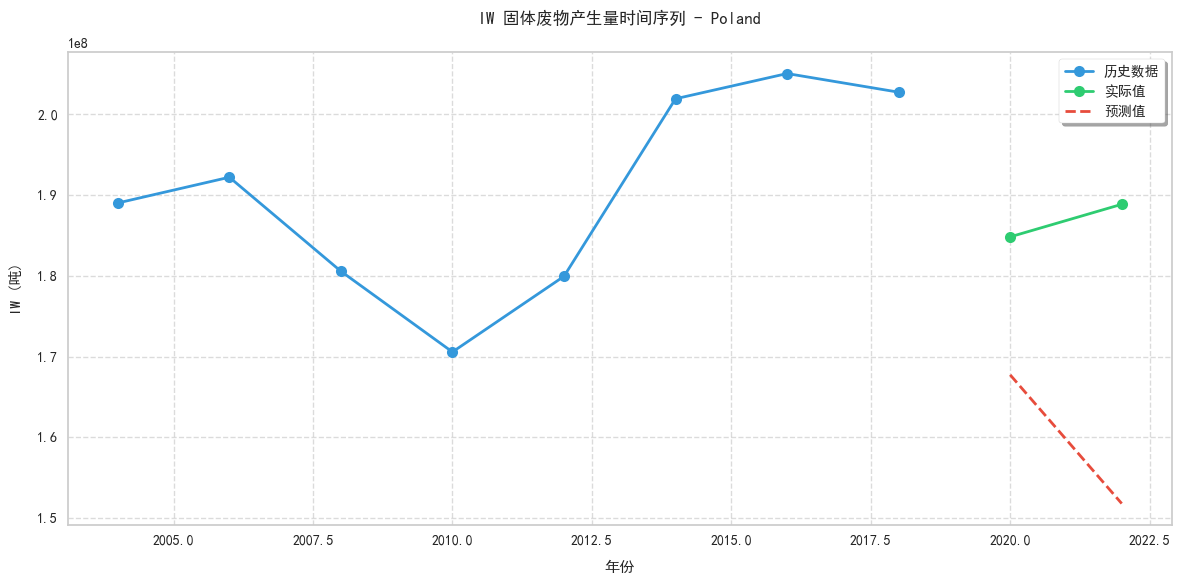

In [9]:
visualizer.plot_all_country_predictions(country_results)
visualizer.plot_top_time_predictions(train_data,time_results)